In [4]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound
from celmech.disturbing_function import laplace_b as b

In [5]:
from celmech.secular import LaplaceLagrangeSystem
from celmech.poincare import Poincare

In [6]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [7]:
def make_sim(alpha, mass, ecc, pom):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu2, mu3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    return sim

In [8]:
def run(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    R1 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    delta = (ec12 - ec23)/ec13
    denom = 3/16+1/2*(mu3-mu1)*delta+3/8*delta**2-delta**4/16
    phi = -np.sqrt(mu1*mu2*mu3)*delta/denom

    R2 = np.array([[np.cos(phi), -np.sin(phi), 0],
                [np.sin(phi), np.cos(phi), 0],
                [0,0,1]])
    R = R2@R1
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
    Gx, Gy = np.zeros((Nout,3)), np.zeros((Nout,3))
    for i, time in enumerate(times):
        sim.integrate(time)
        Gx[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.cos(-p.pomega) for p in ps[1:]]
        Gy[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.sin(-p.pomega) for p in ps[1:]]
    
    Sx = T.T @ Gx.T
    Sy = T.T @ Gy.T

    Sxapprox = R @ Gx.T
    Syapprox = R @ Gy.T
    
    G1, G2, G3 = np.sqrt(Gx**2 + Gy**2).T
    S1, S2, S3 = np.sqrt(Sx**2 + Sy**2)
    S1a, S2a, S3a = np.sqrt(Sxapprox**2 + Syapprox**2)
    
    return times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a

In [9]:
def norun(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    R1 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])

    delta = (ec12 - ec23)/ec13
    denom = 3/16+1/2*(mu3-mu1)*delta+3/8*delta**2-delta**4/16
    phi = -np.sqrt(mu1*mu2*mu3)*delta/denom

    R2 = np.array([[np.cos(phi), -np.sin(phi), 0],
                [np.sin(phi), np.cos(phi), 0],
                [0,0,1]])
    R = R2@R1

    return R

# Test the new S1'

In [252]:
from sympy import *
init_printing()
M1, M2, M3, Mstar, e12, e23, e13, b1_12, b1_23, b1_13, b2_12, b2_23, b2_13, alpha12, alpha23, alpha13, e1, e2, e3 = symbols("m1, m2, m3, Mstar, e_{12}, e_{23}, e_{13}, b1_{12}, b1_{23}, b1_{13}, b2_{12}, b2_{23}, b2_{13}, a_{12}, a_{23}, a_{13}, e_1, e_2, e_3", positive=True, real=True)
eps12, eps23, eps13 = symbols(r"\epsilon_{12}, \epsilon_{23}, \epsilon_{13}", positive=True, real=True)

G = Matrix([sqrt(M1)*e1, sqrt(M2)*e2, sqrt(M3)*e3])

### the eigenmodes by numerically diagonalizing M:

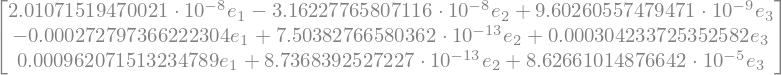

In [365]:
alpha = 0.755, 0.87
mass = 10e-7,1e-15,1e-7
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3
sim = make_sim(alpha, mass, ecc, pomega)
ps = sim.particles
lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
M = lsys.Neccentricity_matrix
vals,T = np.linalg.eigh(M)

T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2])

### the calculated eigenmodes:

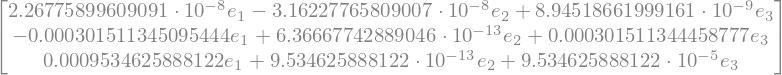

In [366]:
R = norun(sim)
R*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2])

In [384]:
def getT(mass, alpha):
    m1, m3 = mass
    mu1, mu3 = m1/(m1+m3),m3/(m1+m3)
    
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    d = (ec12 - ec23)/ec13
    mu = (mu3-mu1)/(mu1+mu3)
    gamma = 1/(3+6*d**2+8*mu*d-d**4)
    
    T = np.array([[gamma*mu1*(1-d)**3*(3+d), -gamma*(mu3*(1+d)**3*(3-d)+mu1*(1-d)**3*(3+d)), gamma*mu3*(1+d)**3*(3-d)],
                 [-np.sqrt(mu1*mu3), 0, np.sqrt(mu1*mu3)],
                 [mu1, 0, mu3]])
    return T

In [385]:
alpha = 0.9, 0.9
mass = 10e-7,1e-7,10e-7
m1, m2, m3 = mass
# T = getT((m1, m3), alpha)

# print(T[0]*np.sqrt(m2))
# print(T[1]*np.sqrt(m1+m3))
# print(T[2]*np.sqrt(m1+m3))

[ 2.26775860e-08 -3.16227766e-08  8.94519062e-09]
[-0.00030151  0.          0.00030151]
[9.53462589e-04 0.00000000e+00 9.53462589e-05]


### check with NBody

In [39]:
alpha = 0.94, 0.94
mass = 1e-7,1e-7,1e-7
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3
sim = make_sim(alpha, mass, ecc, pomega)

In [40]:
sim = make_sim(alpha, mass, ecc, pomega)
times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)

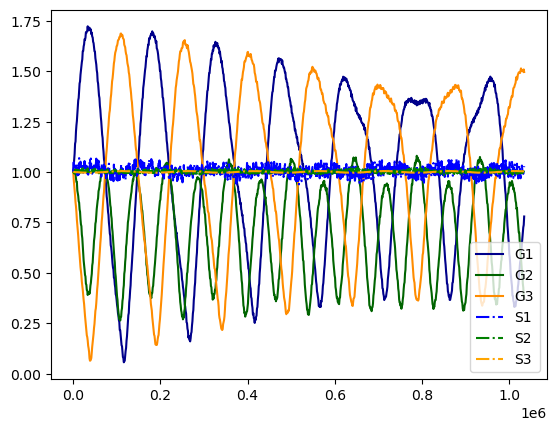

In [41]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1/S1[0], color='blue', linestyle='-.', label='S1')
ax.plot(times, S2/S2[0], color='green', linestyle='-.', label='S2')
ax.plot(times, S3/S3[0], color='orange', linestyle='-.', label='S3')
ax.legend()

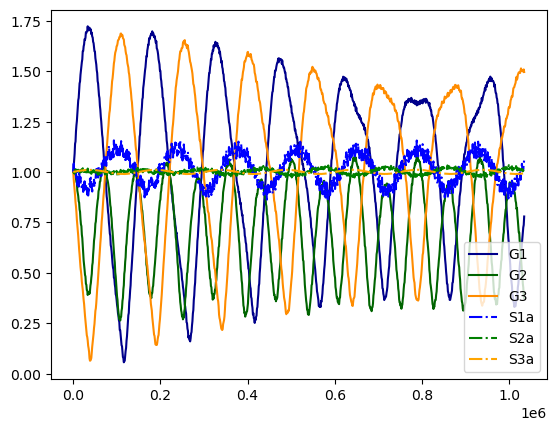

In [42]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1a/S1a[0], color='blue', linestyle='-.', label='S1a')
ax.plot(times, S2a/S2a[0], color='green', linestyle='-.', label='S2a')
ax.plot(times, S3a/S3a[0], color='orange', linestyle='-.', label='S3a')
ax.legend()

# Test psi approximations

In [20]:
def testPsi(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    b12 = alpha12**(1/2)*alpha23**(-3/2)*2/(np.pi*(1-alpha12)**2)
    b23 = alpha23*2/(np.pi*(1-alpha23)**2)
    b13 = alpha13*2/(np.pi*(1-alpha13)**2)
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    Mdiagapprox = R2 @ lsys.Neccentricity_matrix @ R2.T
    phi_theo = 1/2*np.arctan(2*Mdiagapprox[1,0]/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
    
    prefac = - ps[3].n *m_tot/(4*(mu1+mu3))
    w1 = prefac * (mu1*b12 + mu3*b23)
    w2 = prefac * (mu2*mu3*b12 + mu1*mu2*b23 + (mu1+mu3)**2*b13)
    k = prefac * np.sqrt(mu1*mu2*mu3) * (b23*alpha23**(-1/4)-b12*alpha12**(1/4))
    phi_calc = 1/2*np.arctan2(2*k, w2-w1)

    delta = (ec12 - ec23)/ec13
    phi_saa = -np.sqrt(mu1*mu2*mu3/(mu1+mu3)**4)*delta/(3/16+1/2*(mu3-mu1)*delta+3/8*delta**2-delta**4/16)

#     print(delta, phi, phi_approx, (phi-phi_approx)/phi)
    return delta, phi_theo, phi_calc, phi_saa ,(phi_theo-phi_saa)/phi_theo

In [21]:
alpha = 0.9, 0.8
mass = 1e-7,1e-15,1e-7
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3
sim = make_sim(alpha, mass, ecc, pomega)
testPsi(sim)

(-0.3981332566809988, 5.782990309349947e-05, 5.689324621543407e-05, 5.73667612400551e-05, 0.008008691501619144)

In [179]:
mass_param = [[x,y] for x in np.linspace(1,10,2) for y in np.linspace(1,10,2)]
alpha_param = [[x,y] for x in np.linspace(0.75,0.9,4) for y in np.linspace(0.75,0.9,4)]
# alpha_param = np.array([[0.99, 0.75]])
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3

data = np.zeros((100,11))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    for j, (m1, m3) in enumerate(mass_param):
        mass = m1*1e-7, 1e-7, m3*1e-7
        sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
        delta, phi_theo, phi_calc, phi_saa1, phi_saa2, error1, error2 = testPsi(sim)

        data[4*i+j][:] = m1, m3, alpha1, alpha2, delta, phi_theo, phi_calc, phi_saa1, phi_saa2, np.fabs(error1), np.fabs(error2)

In [180]:
pd.set_option('display.max_rows', 5)
df = pd.DataFrame(data, columns=['m1', 'm3', 'alpha_12', 'alpha_23', 'delta', '$\phi_{theo}$', '$\phi_{calc}$', '$\phi_{saa1}$', '$\phi_{saa2}$', 'error1', 'error2'])
df['$\phi_{theo}$'] = df['$\phi_{theo}$'].map('{:e}'.format)
df['$\phi_{calc}$'] = df['$\phi_{calc}$'].map('{:e}'.format)
df['$\phi_{saa1}$'] = df['$\phi_{saa1}$'].map('{:e}'.format)
df['$\phi_{saa2}$'] = df['$\phi_{saa2}$'].map('{:e}'.format)
df

,m1,m3,alpha_12,alpha_23,delta,$\phi_{theo}$,$\phi_{calc}$,$\phi_{saa1}$,$\phi_{saa2}$,error1,error2
0,1.0,1.0,0.75,0.75,-0.092649,1.701170e-05,1.792008e-05,1.747002e-05,1.717558e-05,0.026941,0.009633
1,1.0,10.0,0.75,0.75,-0.092649,5.945442e-06,6.086139e-06,4.283037e-06,5.255264e-06,0.279610,0.116085
...,...,...,...,...,...,...,...,...,...,...,...
98,10.0,1.0,0.95,0.95,-0.018743,8.405559e-07,8.276849e-07,8.664727e-07,8.318695e-07,0.030833,0.010334
99,10.0,10.0,0.95,0.95,-0.018746,1.217875e-06,1.126451e-06,1.117808e-06,1.117023e-06,0.082166,0.082810


In [181]:
df.to_csv("psiTest.csv",index=False)

# Test eigenmodes approximation

In [314]:
# normalized coefficients in front of e1, e2, and e3 (i.e., unit vector in e1, e2 and e3 bases)
def convert(x):
    coeff1 = x.split("*e_1")[0]
    coeff1 = float(coeff1.replace(" ", ""))
    coeff2 = (x.split("*e_1")[1]).split("*e_2")[0]
    coeff2 = float(coeff2.replace(" ", ""))
    coeff3 = ((x.split("*e_1")[1]).split("*e_2")[1]).split("*e_3")[0]
    coeff3 = float(coeff3.replace(" ", ""))
    
    return 1/np.sqrt(coeff1**2+coeff2**2+coeff3**2) * np.array([coeff1, coeff2, coeff3])

In [360]:
def modeDistance(sim):
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M)
    exp_theo1 = (T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[0]
    vec_theo1 = convert(str(exp_theo1))
    exp_theo2 = (T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[1]
    vec_theo2 = convert(str(exp_theo2))

    R = norun(sim)
    exp_approx1 = (R*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[0]
    vec_approx1 = convert(str(exp_approx1))
    exp_approx2 = (R*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[1]
    vec_approx2 = convert(str(exp_approx2))
    
    if vec_theo1[0] * vec_approx1[0] > 0:
        dist1 = np.linalg.norm(vec_theo1-vec_approx1)
    else:
        dist1 = np.linalg.norm(vec_theo1+vec_approx1)
    if vec_theo2[0] * vec_approx2[0] > 0:
        dist2 = np.linalg.norm(vec_theo2-vec_approx2)
    else:
        dist2 = np.linalg.norm(vec_theo2+vec_approx2)
    
    return dist1, dist2

### NBody test

In [ ]:
mass_param = [[x,y] for x in np.array([1,3,10]) for y in np.array([1,3,10])]
alpha_param = [[x,y] for x in np.linspace(0.75,0.9,4) for y in np.linspace(0.75,0.9,4)]
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3

data = np.zeros((144,15))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    for j, (m1, m3) in enumerate(mass_param):
        mass = m1*1e-7, 1e-7, m3*1e-7
        sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
        dist1, dist2 = modeDistance(sim)
        
        delta, phi_theo, phi_calc, phi_saa1, phi_saa2, error1, error2 = testPsi(sim)
        
        times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)
        amp_G1, amp_S1, amp_G2, amp_S2 = (max(G1)-min(G1))/(2*np.mean(G1)), (max(S1a)-min(S1a))/(2*np.mean(S1a)), (max(G2)-min(G2))/(2*np.mean(G2)), (max(S2a)-min(S2a))/(2*np.mean(S2a))
        
        data[i*9+j][:] = m1, m3, alpha1, alpha2, amp_G1, amp_S1, amp_G2, amp_S2, dist1, dist2, amp_S1/amp_G2, amp_S1/amp_G1, phi_theo, phi_saa2, error2
#         data[i*9+j][:] = m1, m3, alpha1, alpha2, dist1, dist2, phi_theo, phi_saa2, error2

In [ ]:
pd.set_option('display.max_rows', 10)
df = pd.DataFrame(data, columns=['m1','m3','alpha12','alpha23','G1','S1','G2','S2','dist1','dist2','S1/G2','S1/G1','phi_theo','phi_approx','phi_error'], index=None)
# df = pd.DataFrame(data, columns=['m1','m3','alpha12','alpha23','dist1','dist2','phi_theo','phi_approx','phi_error'], index=None)

df['phi_theo'] = df['phi_theo'].map('{:e}'.format)
df['phi_approx'] = df['phi_approx'].map('{:e}'.format)
df

In [ ]:
df.to_csv("ModeAmp.csv",index=False)

-----------------------------------------------------------------------------------------------------------------

In [ ]:
def compareModes(sim, mass, mu):
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M)
    exp_theo = (T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[0]
    coeff_theo = convert(str(exp_theo), mu)
    
    R, delta = testModes(sim)
    exp_approx = (R*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[0]
    coeff_approx = convert(str(exp_approx), mu)
    
    mu1, mu2, mu3 = mu
    coeff_saa = np.array([np.sqrt(mass[1]), np.sqrt(mass[1])*(mu1*mu3*delta/(3/16+1/2*(mu3-mu1)*delta+3/8*delta**2))])
    
    return coeff_theo[0:2], coeff_approx[0:2], coeff_saa

In [ ]:
mass_param = [[x,y] for x in np.linspace(1,10,3) for y in np.linspace(1,10,3)]
alpha_param = [[x,y] for x in np.linspace(0.75,0.95,10) for y in np.linspace(0.75,0.95,10)]
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3

data = np.zeros((900,12))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    for j, (m1, m3) in enumerate(mass_param):
        mass = m1*1e-7, 1e-15, m3*1e-7
        m_tot = mass[0]+mass[1]+mass[2]
        mu = (mass[0]/m_tot, mass[1]/m_tot, mass[2]/m_tot)
        
        sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
        compareModes(sim, mass, mu)
        theo, approx, saa = compareModes(sim, mass, mu)
        data[i*9+j][:] = m1, m3, alpha1, alpha2, theo[0], approx[0], saa[0], np.fabs((theo[0]-saa[0])/theo[0]), theo[1], approx[1], saa[1], np.fabs((theo[1]-saa[1])/theo[1])

In [ ]:
df = pd.DataFrame(data, columns=['$m_1$', '$m_3$', r'$\alpha_{12}$',r'$\alpha_{23}$','co1$_{theo}$','co1$_{approx}$','co1$_{saa}$','$err1$','co2$_{theo}$','co2$_{approx}$','co2$_{saa}$','$err2$'], index=None)
df

In [ ]:
df.to_csv("ErrInMode(vectorDiff).csv",index=False)